In [30]:
import os
import numpy as np
import re

# sys.path.insert(1, '../../ProcessEvents')
from Convert_to_Profiles_Functions import *
from Get_Events_Functions import *
from Steef_Functions import *

In [283]:
def create_event_characteristics_dict(this_event):
    
    max_quintile_molly=find_max_quintile(this_event['precipitation (mm)'],5)
    max_third_molly=find_max_quintile(this_event['precipitation (mm)'],3)
    max_quintile_steef=analyse_event(this_event['precipitation (mm)'])[0]
    duration = len(this_event) / 2
    DurationRange_personalised_allems = find_dur_category([1.5, 5.0, 11.5, 22.5, 166.5], ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    DurationRange_notpersonalised = find_dur_category([0.25, 2.10, 6.45, 19.25, 1000], 
                                                      ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    return {
        "season" : get_season(this_event['times'][0]),
        'duration':duration,
        "DurationRange_personalised_allems": DurationRange_personalised_allems,
        'DurationRange_notpersonalised':DurationRange_notpersonalised,
        "year":extract_year(this_event),
        "month":get_month(this_event),
        'Volume': sum(this_event['precipitation (mm)'].values),
        'max_intensity': this_event['precipitation (mm)'].max() *2,
        "max_quintile_molly":max_quintile_molly,
        "max_third_molly": max_third_molly,
        'max_quintile_steef' :max_quintile_steef,
        'Loading_profile_molly' :quintile_mapping[max_quintile_molly],
        'Loading_profile_third_molly':quintile_mapping_thirds[max_third_molly],
        'Loading_profile_steef':quintile_mapping[max_quintile_steef],
        'D50_index': calculate_D50(this_event['precipitation (mm)'])[1]
    }

def find_max_quintile (precip, n):
    # Difference with this to Huff curve function, is it doesnt normalise
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 

def find_dur_category (bin_edges, duration_labels, duration):
    # Create a pandas Series with the duration
    # Use pd.cut to assign the duration to a bin
    binned_duration = pd.cut(pd.Series([duration]), bins=bin_edges, labels=duration_labels, right=True,  include_lowest=True)
    return binned_duration.iloc[0]

def get_month (df):
    # Step 2: Calculate the median (middle value)
    median_time = df['times'].median()

    # Step 3: Extract the month from the median value
    median_month = median_time.month

    # Convert month number to month name (optional)
    month_name = median_time.strftime('%B')

    return median_month

def calculate_D50(precipitation_values):
    """
    Calculate D50, the point in time when 50% of cumulative precipitation has occurred during an event.
    
    Parameters:
    - precipitation_values: A list or array of precipitation values for a given event.
    
    Returns:
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    """
    # Ensure input is a numpy array
    precipitation_values = np.array(precipitation_values)
    
    # Step 1: Calculate the cumulative precipitation
    cumulative_precip = np.cumsum(precipitation_values)
    
    # Step 2: Determine the total precipitation
    total_precip = cumulative_precip[-1]
    
    # Step 3: Find the index where 50% of the total precipitation is reached
    halfway_precip = total_precip / 2.0
    D50_index = np.where(cumulative_precip >= halfway_precip)[0][0]  # First index where cumulative precipitation >= 50%
    
    # Step 4: Calculate the percentage of the event duration (D50)
    total_timesteps = len(precipitation_values)
    D50 = (D50_index / (total_timesteps - 1)) * 100

    return D50, D50_index, cumulative_precip

def create_profiles_dict(this_event):
    dimensionless_cumulative_rainfall, dimensionless_cumulative_times = create_huff_curves(this_event['precipitation (mm)'])
    interpolated_cumulative_rainfall, interpolated_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
    irain_14vals, irain_times_14vals = create_irain_profile(interpolated_cumulative_rainfall, True)
    irain, irain_times = create_irain_profile(interpolated_cumulative_rainfall, False)
    return {
        "dimensionless_cumulative_rainfall" : dimensionless_cumulative_rainfall,
        'dimensionless_cumulative_times':dimensionless_cumulative_times,
        "interpolated_cumulative_rainfall": interpolated_cumulative_rainfall,
        'interpolated_times':interpolated_times,
        "irain_14vals":irain_14vals,
        'irain_times_14vals': irain_times_14vals,
        "irain":irain,
        "irain_times": irain_times} 

def get_dur_for_which_this_is_amax(file):
    match = re.search(r'(\d+(\.\d+)?)hrs', file)

    # Extract and print the result if a match is found
    if match:
        extracted_value = match.group(1)
        return extracted_value
    
def adjust_feb_dates(datetime_str):
    try:
        # Split the string into date and time parts (assuming standard format)
        date_part, time_part = datetime_str.split(' ')
        year, month, day = map(int, date_part.split('-'))
        
        # Check if it's February and the day is invalid (29th or 30th)
        if month == 2 and day in [29, 30]:
            # Return the date as February 28th, keeping the time part intact
            return f'{year}-02-28 {time_part}'
        
        # Return the original datetime string if valid
        return datetime_str
    except:
        # In case of unexpected formats or errors, return the original string
        return datetime_str    

In [340]:
def plot_polar_months_plot(event_props_dict, ax, title, rmax, name_variable_to_plot):
    
    months = [event['month'] for event in event_props_dict.values()]
    months_df = pd.DataFrame({'month':months})
    len(months_df)
    
    N = 12
    width = (2*np.pi) / N
    bottom = 8
    
    # Define bins and their positions
    circular_bins = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    circular_bins = np.append(circular_bins, 2 * np.pi)
    circular_plot_position = circular_bins + 0.5*np.diff(circular_bins)[0]
    circular_plot_position = circular_plot_position[:-1]
    circular_plot_position = circular_plot_position + 0.5*np.pi
    
    # Count numbers in each month
    count = months_df['month'].value_counts().sort_index()
    count = count.reindex(list(range(count.index.min(),count.index.max()+1)),fill_value=0)
    
    # Calculate percentage
    total_events = count.sum()
    percentage = (count / total_events) * 100  # Calculate percentage for each month
    
    if name_variable_to_plot == 'Percentage':
        variable_to_plot = percentage
    elif name_variable_to_plot == 'Count':
        variable_to_plot = count
    
    # Define colors for each month
    colors = [
              '#0033cc',  # Jan (Light Blue)
              '#0033cc',  # Feb (Very Light Blue)
              '#ffcc00',  # Mar (Purple)
              '#ffcc00',  # Apr (Medium Purple)
              '#ffcc00',  # May (Bright Yellow)
              '#ff8c00',  # Jun (Red-Orange)
              '#ff8c00',  # Jul (Tomato Red)
              '#ff8c00',  # Aug (Dark Orange)
              '#8b4513',  # Sep (Saddle Brown)
              '#8b4513',  # Oct (Orange)
              '#8b4513',# Nov (Dark Goldenrod)
              '#0033cc',  # Dec (Dark Blue)
    ]  
    colors.reverse()
    
    # Plot
    ax.bar(circular_plot_position, variable_to_plot.iloc[::-1], width=width, color=colors)
    

    # Format
    ax.set_title(title, fontsize=20, pad=50)
    ax.set_rlabel_position(90)
    ax.xaxis.grid(False)
    if name_variable_to_plot == 'Percentage':
        ax.set_ylim(0, rmax)
    ax.set_xticks(circular_plot_position - 0.5*np.pi)
    ax.set_xticklabels(['Mar', 'Feb', 'Jan',
                         'Dec', 'Nov', 'Oct',
                        'Sep', 'Aug', 'Jul',
                        'Jun', 'May', 'Apr'])
    
    
def plot_polar_months_plot_overlay(months_df_present, months_df_future, ax, title):
    
       
    N = 12
    width = (2 * np.pi) / N
    
    # Define bins and their positions
    circular_bins = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    circular_bins = np.append(circular_bins, 2 * np.pi)
    circular_plot_position = circular_bins + 0.5 * np.diff(circular_bins)[0]
    circular_plot_position = circular_plot_position[:-1]
    circular_plot_position = circular_plot_position + 0.5 * np.pi
    
    # Count numbers in each month for present and future datasets
    count_present = months_df_present['month'].value_counts().sort_index()
    count_present = count_present.reindex(list(range(count_present.index.min(), count_present.index.max() + 1)), fill_value=0)
    total_present = count_present.sum()
    percentage_present = (count_present / total_present) * 100
    
    count_future = months_df_future['month'].value_counts().sort_index()
    count_future = count_future.reindex(list(range(count_future.index.min(), count_future.index.max() + 1)), fill_value=0)
    total_future = count_future.sum()
    percentage_future = (count_future / total_future) * 100
    
    # Define colors for each dataset
    colors_present = '#ffcc00'  # Yellow for present
    colors_future = '#0033cc'    # Blue for future

    # Plot percentage for present and future datasets
    ax.bar(circular_plot_position, percentage_present.iloc[::-1], width=width, color=colors_present, alpha=0.5, label='Present')
    ax.bar(circular_plot_position, percentage_future.iloc[::-1], width=width, color=colors_future, alpha=0.5, label='Future')

    # Format
    ax.set_title(title, fontsize=20, pad=50)
    ax.set_rlabel_position(90)
    ax.xaxis.grid(False)
    ax.set_ylim(0, 20)  # Set limit based on percentage (0 to 100)
    ax.set_xticks(circular_plot_position - 0.5 * np.pi)
    ax.set_xticklabels(['Mar', 'Feb', 'Jan',
                        'Dec', 'Nov', 'Oct',
                        'Sep', 'Aug', 'Jul',
                        'Jun', 'May', 'Apr'])
    
    # Add legend
    ax.legend(loc='upper right')
    

In [8]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [36]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}

In [348]:
ems_present = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc012', 'bc013', 'bc015', 'bc016', 'bc017', 'bc018']
ems_future = ['bb189','bb192', 'bb195', 'bb198', 'bb201', 'bb204','bb208' ,'bb211','bb216', 'bb219','bb222','bb225']

In [314]:
def process_events(time_period, ems):
    events_dict = {}
    event_props_dict = {}
    event_profiles_dict = {}

    for em in ems:
        print(em)
        for gauge_num in range(0, 1293):
            if gauge_num not in [444, 827, 888]:
                if gauge_num % 100 == 0:
                    print(f"Processing gauge {gauge_num}")
                    indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/"

                    files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
                    files = np.sort(files)

                    for event_num, file in enumerate(files):
                        fp = indy_events_fp + f"{file}"
                        if '2080' in fp:
                            continue
                        
                        # Get event
                        this_event = read_event(gauge_num, fp)

                        # Get times and precipitation values
                        event_times = this_event['times']
                        event_precip = this_event['precipitation (mm)']

                        # Apply the function to adjust the dates in the 'times' column
                        event_times_fixed = event_times.apply(adjust_feb_dates)

                        # Create the DataFrame with corrected times
                        event_df = pd.DataFrame({'precipitation (mm)': event_precip, 'times': event_times_fixed})

                        # Create characteristics dictionary
                        event_props = create_event_characteristics_dict(event_df)

                        # Add the duration
                        event_props['dur_for_which_this_is_amax'] = get_dur_for_which_this_is_amax(fp)
                        # Add gauge number and ensemble member
                        event_props['gauge_num'] = gauge_num
                        event_props['em'] = em
                        event_props['filename'] = file

                        event_profiles = create_profiles_dict(event_df)

                        events_dict[f"{em}, {gauge_num}, {event_num}"] = event_df
                        event_props_dict[f"{em}, {gauge_num}, {event_num}"] = event_props
                        event_profiles_dict[f"{em}, {gauge_num}, {event_num}"] = event_profiles

    return events_dict, event_props_dict, event_profiles_dict

# Now you can call the function for both time periods
events_dict_present, event_props_dict_present, event_profiles_dict_present = process_events('Present',ems_present)
events_dict_future, event_props_dict_future, event_profiles_dict_future = process_events('Future', ems_future)

bc005
Processing gauge 0
Processing gauge 100
Processing gauge 200
Processing gauge 300
Processing gauge 400
Processing gauge 500
Processing gauge 600
Processing gauge 700
Processing gauge 800
Processing gauge 900
Processing gauge 1000
Processing gauge 1100
Processing gauge 1200
bc006
Processing gauge 0
Processing gauge 100
Processing gauge 200
Processing gauge 300
Processing gauge 400
Processing gauge 500
Processing gauge 600
Processing gauge 700
Processing gauge 800
Processing gauge 900
Processing gauge 1000
Processing gauge 1100
Processing gauge 1200
bc007
Processing gauge 0
Processing gauge 100
Processing gauge 200
Processing gauge 300
Processing gauge 400
Processing gauge 500
Processing gauge 600
Processing gauge 700
Processing gauge 800
Processing gauge 900
Processing gauge 1000
Processing gauge 1100
Processing gauge 1200
bc009
Processing gauge 0
Processing gauge 100
Processing gauge 200
Processing gauge 300
Processing gauge 400
Processing gauge 500
Processing gauge 600
Processin

In [350]:
def process_events_by_duration(time_period, valid_durations, ems):
    events_dict = {duration: {} for duration in valid_durations}
    event_props_dict = {duration: {} for duration in valid_durations}
    event_profiles_dict = {duration: {} for duration in valid_durations}

    for em in ems:  # You can add more ensemble members as needed
        print(em)
        for gauge_num in range(0, 1293):
            if gauge_num not in [444, 827, 888]:
                if gauge_num % 100 == 0:
                    print(f"Processing gauge {gauge_num}")
                    indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"

                    files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
                    files = np.sort(files)

                    for event_num, file in enumerate(files):
                        fp = indy_events_fp + f"{file}"
                        if '2080' in fp:
                            continue

                        # Get duration for this event
                        duration_of_this_event = get_dur_for_which_this_is_amax(fp)
                        if duration_of_this_event not in valid_durations:
                            continue  # Skip if not in the list of valid durations

                        # print(f"Processing event file: {file} with duration: {duration_of_this_event}")

                        # Get event
                        this_event = read_event(gauge_num, fp)

                        # Get times and precipitation values
                        event_times = this_event['times']
                        event_precip = this_event['precipitation (mm)']

                        # Apply the function to adjust the dates in the 'times' column
                        event_times_fixed = event_times.apply(adjust_feb_dates)

                        # Create the DataFrame with corrected times
                        event_df = pd.DataFrame({'precipitation (mm)': event_precip, 'times': event_times_fixed})

                        # Create characteristics dictionary
                        event_props = create_event_characteristics_dict(event_df)

                        # Add the duration
                        event_props['dur_for_which_this_is_amax'] = duration_of_this_event
                        # Add gauge number and ensemble member
                        event_props['gauge_num'] = gauge_num
                        event_props['em'] = em
                        event_props['filename'] = file

                        # Store results in corresponding duration category
                        events_dict[duration_of_this_event][f"{em}, {gauge_num}, {event_num}"] = event_df
                        event_props_dict[duration_of_this_event][f"{em}, {gauge_num}, {event_num}"] = event_props
                        event_profiles_dict[duration_of_this_event][f"{em}, {gauge_num}, {event_num}"] = create_profiles_dict(event_df)

    return events_dict, event_props_dict, event_profiles_dict

# List of desired durations
valid_durations = ["0.5", "1", "2", "3", "6", "12", "24"]

# Process events for both time periods
# results_present = process_events_by_duration('Present', valid_durations, ems_present)
results_future = process_events_by_duration('Future', valid_durations, ems_future)

# You can access results like this:
# results_present[0.5]  # Events with a duration of 0.5 hours for Present
# results_future[1]     # Events with a duration of 1 hour for Future


bb189
Processing gauge 0
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2

Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration:

Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 200
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.

Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 300
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5

Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with dura

Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with dura

Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with dura

Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with dura

Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with dura

Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with dura

Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with dura

Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with dura

Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with dura

Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with dura

Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with dura

Processing event file: 24hrs_2076_v2_part1.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part1.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv

Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part1.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part1.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part1.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_206

Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part1.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part1.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part1.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part1.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs

Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part1.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071

Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv wi

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with dura

Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with

Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part1.csv with duration: 24
Processing event file: 24hrs_2067_v2_pa

Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with dura

Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with 

Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with dura

Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with dura

Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with dura

Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with dura

Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part1.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.

Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with dura

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv w

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with 

Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with

Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with dura

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv wit

Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_206

Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs

Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs

Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.c

Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with d

Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.cs

Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part

Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv 

Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_20

Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part1.csv with duration: 24
Processing event file: 24hr

Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part1.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_20

Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part1.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part1.

Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with dura

Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with dura

Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv wit

Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with 

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv w

Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_p

Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_

Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs

Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_206

Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part1.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event fi

Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Process

Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration:

Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 300
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.

Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 400
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing

Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 500
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.

Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 600
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file:

Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 700
Processing event file: 0.5hrs_2061

Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with dura

Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with dura

Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with dura

Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with dura

Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with dura

Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with dura

Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with dura

Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with dura

Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with dura

Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with dura

Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv

Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv wit

Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with dura

Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part1.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with 

Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with dura

Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with dura

Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with 

Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with dura

Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part1.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part1.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_

Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part1.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part1.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part1.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v

Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part1.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070

Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part1.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_

Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with d

Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with dura

Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with du

Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv

Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_p

Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0

Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv

Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part1.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part1.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part1.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2

Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part1.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12

Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part1.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12

Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing even

Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event fi

Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing 

Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part1.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 

Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part1.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processin

Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing 

Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing 

Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing ev

Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event fi

Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part1.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12

Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part1.csv with duration: 12
Processing event fi

Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
bb219
Processing gauge 0
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.c

Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 100
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv w

Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 200
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2064_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2065_v2_part0.csv with duration: 0.5
Processing eve

Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 300
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file:

Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with duration: 6
Processing gauge 400
Processing event file: 0.5hrs_2061_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2062_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2063_v2_part0.csv with duration: 0.5
Processing event file:

Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with duration: 6
Processing event file: 6hrs_2075_v2_part0.csv with duration: 6
Processing event file: 6hrs_2076_v2_part0.csv with duration: 6
Processing event file: 6hrs_2077_v2_part0.csv with duration: 6
Processing event file: 6hrs_2078_v2_part0.csv with duration: 6
Processing event file: 6hrs_2079_v2_part0.csv with dura

Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with duration: 6
Processing event file: 6hrs_2064_v2_part0.csv with duration: 6
Processing event file: 6hrs_2065_v2_part0.csv with duration: 6
Processing event file: 6hrs_2066_v2_part0.csv with duration: 6
Processing event file: 6hrs_2067_v2_part0.csv with duration: 6
Processing event file: 6hrs_2068_v2_part0.csv with duration: 6
Processing event file: 6hrs_2069_v2_part0.csv with duration: 6
Processing event file: 6hrs_2070_v2_part0.csv with duration: 6
Processing event file: 6hrs_2071_v2_part0.csv with duration: 6
Processing event file: 6hrs_2072_v2_part0.csv with duration: 6
Processing event file: 6hrs_2073_v2_part0.csv with duration: 6
Processing event file: 6hrs_2074_v2_part0.csv with dura

Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with duration: 3
Processing event file: 3hrs_2075_v2_part0.csv with duration: 3
Processing event file: 3hrs_2076_v2_part0.csv with duration: 3
Processing event file: 3hrs_2077_v2_part0.csv with duration: 3
Processing event file: 3hrs_2078_v2_part0.csv with duration: 3
Processing event file: 3hrs_2079_v2_part0.csv with duration: 3
Processing event file: 6hrs_2061_v2_part0.csv with duration: 6
Processing event file: 6hrs_2062_v2_part0.csv with duration: 6
Processing event file: 6hrs_2063_v2_part0.csv with dura

Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with duration: 3
Processing event file: 3hrs_2066_v2_part0.csv with duration: 3
Processing event file: 3hrs_2067_v2_part0.csv with duration: 3
Processing event file: 3hrs_2068_v2_part0.csv with duration: 3
Processing event file: 3hrs_2069_v2_part0.csv with duration: 3
Processing event file: 3hrs_2070_v2_part0.csv with duration: 3
Processing event file: 3hrs_2071_v2_part0.csv with duration: 3
Processing event file: 3hrs_2072_v2_part0.csv with duration: 3
Processing event file: 3hrs_2073_v2_part0.csv with duration: 3
Processing event file: 3hrs_2074_v2_part0.csv with dura

Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with duration: 2
Processing event file: 3hrs_2061_v2_part0.csv with duration: 3
Processing event file: 3hrs_2062_v2_part0.csv with duration: 3
Processing event file: 3hrs_2063_v2_part0.csv with duration: 3
Processing event file: 3hrs_2064_v2_part0.csv with duration: 3
Processing event file: 3hrs_2065_v2_part0.csv with dura

Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with duration: 2
Processing event file: 2hrs_2076_v2_part0.csv with duration: 2
Processing event file: 2hrs_2077_v2_part0.csv with duration: 2
Processing event file: 2hrs_2078_v2_part0.csv with duration: 2
Processing event file: 2hrs_2079_v2_part0.csv with dura

Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0.csv with duration: 2
Processing event file: 2hrs_2070_v2_part0.csv with duration: 2
Processing event file: 2hrs_2071_v2_part0.csv with duration: 2
Processing event file: 2hrs_2072_v2_part0.csv with duration: 2
Processing event file: 2hrs_2073_v2_part0.csv with duration: 2
Processing event file: 2hrs_2074_v2_part0.csv with duration: 2
Processing event file: 2hrs_2075_v2_part0.csv with du

Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part1.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_p

Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part1.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part1.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0

Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2_part0.csv with duration: 2
Processing event file: 2hrs_2067_v2_part0.csv with duration: 2
Processing event file: 2hrs_2068_v2_part0.csv with duration: 2
Processing event file: 2hrs_2069_v2_part0

Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part1.csv with duration: 24
Processing event file: 24hrs_2077_v2_part0.csv with duration: 24
Processing event file: 24hrs_2078_v2_part0.csv with duration: 24
Processing event file: 24hrs_2079_v2_part0.csv with duration: 24
Processing event file: 2hrs_2061_v2_part0.csv with duration: 2
Processing event file: 2hrs_2062_v2_part0.csv with duration: 2
Processing event file: 2hrs_2063_v2_part0.csv with duration: 2
Processing event file: 2hrs_2064_v2_part0.csv with duration: 2
Processing event file: 2hrs_2065_v2_part0.csv with duration: 2
Processing event file: 2hrs_2066_v2

Processing event file: 24hrs_2065_v2_part1.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part1.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part1.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part1.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24hrs_2076_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part1.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24hrs_2075_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part1.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_2073_v2_part0.csv with duration: 24
Processing event file: 24hrs_2074_v2_part0.csv with duration: 24
Processing event file: 24

Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part1.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2070_v

Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.csv with duration: 24
Processing event file: 24hrs_2068_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part0.csv with duration: 24
Processing event file: 24hrs_2069_v2_part1.csv with duration: 24
Processing event file: 24hrs_2070_v2_part0.csv with duration: 24
Processing event file: 24hrs_2071_v2_part0.csv with duration: 24
Processing event file: 24hrs_2072_v2_part0.csv with duration: 24
Processing event file: 24hrs_

Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv with duration: 24
Processing event file: 24hrs_2066_v2_part0.csv with duration: 24
Processing event file: 24hrs_2067_v2_part0.

Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with d

Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2064_v2_part0.csv with duration: 24
Processing event file: 24hrs_2065_v2_part0.csv 

Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part1.csv wi

Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with duration: 1
Processing event file: 1hrs_2077_v2_part0.csv with duration: 1
Processing event file: 1hrs_2078_v2_part0.csv with duration: 1
Processing event file: 1hrs_2079_v2_part0.csv with duration: 1
Processing event file: 24hrs_2061_v2_part0.csv with duration: 24
Processing event file: 24hrs_2062_v2_part0.csv with duration: 24
Processing event file: 24hrs_2063_v2_part0.csv with

Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv with duration: 1
Processing event file: 1hrs_2073_v2_part0.csv with duration: 1
Processing event file: 1hrs_2074_v2_part0.csv with duration: 1
Processing event file: 1hrs_2075_v2_part0.csv with duration: 1
Processing event file: 1hrs_2076_v2_part0.csv with dura

Processing event file: 12hrs_2071_v2_part1.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_p

Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_p

Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_part0.csv with duration: 1
Processing event file: 1hrs_2069_v2_part0.csv with duration: 1
Processing event file: 1hrs_2070_v2_part0.csv with duration: 1
Processing event file: 1hrs_2071_v2_part0.csv with duration: 1
Processing event file: 1hrs_2072_v2_part0.csv w

Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_2064_v2_part0.csv with duration: 1
Processing event file: 1hrs_2065_v2_part0.csv with duration: 1
Processing event file: 1hrs_2066_v2_part0.csv with duration: 1
Processing event file: 1hrs_2067_v2_part0.csv with duration: 1
Processing event file: 1hrs_2068_v2_par

Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs_2062_v2_part0.csv with duration: 1
Processing event file: 1hrs_2063_v2_part0.csv with duration: 1
Processing event file: 1hrs_206

Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs

Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part1.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 12hrs_2075_v2_part0.csv with duration: 12
Processing event file: 12hrs_2076_v2_part0.csv with duration: 12
Processing event file: 12hrs_2077_v2_part0.csv with duration: 12
Processing event file: 12hrs_2078_v2_part0.csv with duration: 12
Processing event file: 12hrs_2079_v2_part0.csv with duration: 12
Processing event file: 1hrs_2061_v2_part0.csv with duration: 1
Processing event file: 1hrs

Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file: 12hrs_2074_v2_part0.csv with duration: 12
Processing event file: 

Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event file: 12hrs_2072_v2_part0.csv with duration: 12
Processing event file: 12hrs_2073_v2_part0.csv with duration: 12
Processing event file

Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
Processing event file: 12hrs_2064_v2_part0.csv with duration: 12
Processing event file: 12hrs_2065_v2_part0.csv with duration: 12
Processing event file: 12hrs_2066_v2_part0.csv with duration: 12
Processing event file: 12hrs_2067_v2_part0.csv with duration: 12
Processing event file: 12hrs_2068_v2_part0.csv with duration: 12
Processing event file: 12hrs_2069_v2_part0.csv with duration: 12
Processing event file: 12hrs_2070_v2_part0.csv with duration: 12
Processing event file: 12hrs_2071_v2_part0.csv with duration: 12
Processing event 

Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 12
Processing event file: 12hrs_2062_v2_part0.csv with duration: 12
Processing event file: 12hrs_2063_v2_part0.csv with duration: 12
P

Processing event file: 0.5hrs_2066_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2067_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2068_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2069_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2070_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2071_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2072_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2073_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2074_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2075_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2076_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2077_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2078_v2_part0.csv with duration: 0.5
Processing event file: 0.5hrs_2079_v2_part0.csv with duration: 0.5
Processing event file: 12hrs_2061_v2_part0.csv with duration: 

In [352]:
dur_present_events_dict, dur_present_event_props_dict, dur_present_event_profiles_dict = results_present
dur_future_events_dict, dur_future_event_props_dict, dur_future_event_profiles_dict = results_future

## Do we have the same number of results for each duration?
I think we should

In [311]:
for duration in valid_durations:
    print(duration, len(event_props_dict[duration].keys()))

0.5 247
1 247
2 247
3 247
6 247
12 250
24 291


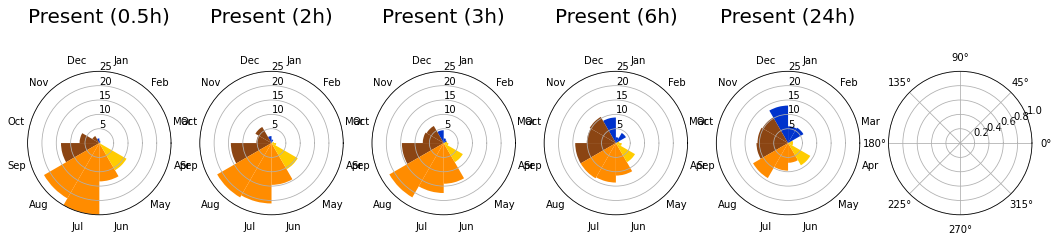

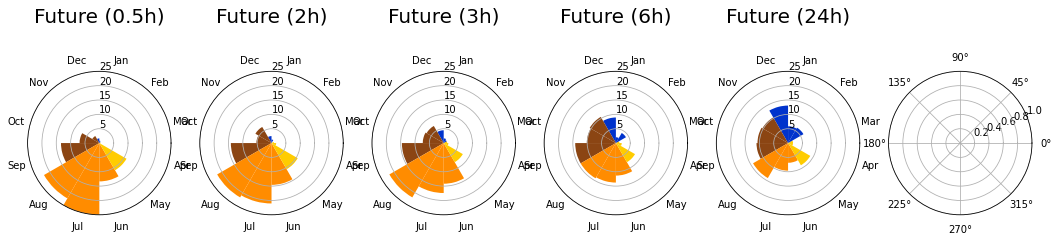

In [353]:
fig, axes = plt.subplots(1, 6, figsize=(18, 10), subplot_kw={'polar': True})
fig.subplots_adjust(hspace=0.5)

# List of durations and corresponding subplot titles
durations = ['0.5', '2', '3', '6', '24']
titles = ["Present (0.5h)",  "Present (2h)", "Present (3h)", "Present (6h)", "Present (24h)"]

# Loop through durations, axes, and titles
for ax, duration, title in zip(axes, durations, titles):
    if duration in event_props_dict:  # Only plot for available durations
        plot_polar_months_plot(event_props_dict[duration], ax, title, 25, name_variable_to_plot='Percentage')

plt.show()



In [ ]:

fig, axes = plt.subplots(1, 6, figsize=(18, 10), subplot_kw={'polar': True})
fig.subplots_adjust(hspace=0.5)
titles = ["Future (0.5h)",  "Future (2h)", "Future (3h)", "Future (6h)", "Future (24h)"]

# Loop through durations, axes, and titles
for ax, duration, title in zip(axes, durations, titles):
    if duration in event_props_dict:  # Only plot for available durations
        plot_polar_months_plot(event_props_dict[duration], ax, title, 25, name_variable_to_plot='Percentage')

plt.show()

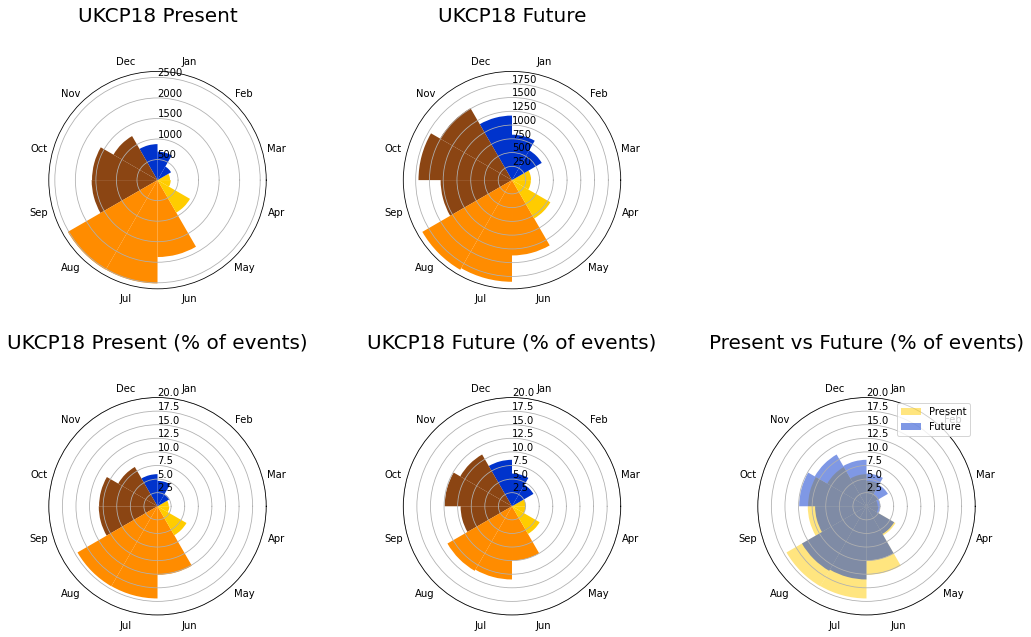

In [252]:
max_present = months_df_present['month'].value_counts().max()
max_future = months_df_future['month'].value_counts().max()
rmax = max(max_present, max_future) + 500  # Adjust to leave space above bars    
    
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot(231, polar=True)
ax2 = plt.subplot(232, polar=True)
plot_polar_months_plot(months_df_present, ax1, "UKCP18 Present", rmax, name_variable_to_plot = 'Count')
plot_polar_months_plot(months_df_future, ax2,"UKCP18 Future", rmax, name_variable_to_plot = 'Count')

ax3 = plt.subplot(234, polar=True)
ax4 = plt.subplot(235, polar=True)
ax5 = plt.subplot(236, polar=True)
plot_polar_months_plot(months_df_present, ax3, "UKCP18 Present (% of events)", rmax, name_variable_to_plot = 'Percentage')
plot_polar_months_plot(months_df_future, ax4,"UKCP18 Future (% of events)", rmax, name_variable_to_plot = 'Percentage')
plot_polar_months_plot_overlay(months_df_present, months_df_future, ax5, "Present vs Future (% of events)")